In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
torch.set_default_device('cuda')

In [ ]:
def generate_angle_vector(beta_star, angle_degrees):
  """
  Generates a unit-norm vector at a specified angle to beta_star.

  Args:
    beta_star: The input vector.
    angle_degrees: The desired angle in degrees.

  Returns:
    A unit-norm vector at the specified angle to beta_star.
  """

  beta_star = beta_star.reshape(-1)

  # Generate a random vector
  random_vector = torch.randn(beta_star.shape)

  # Orthogonalize the random vector to beta_star using Gram-Schmidt
  orthogonal_vector = random_vector - (torch.dot(random_vector, beta_star) / torch.dot(beta_star, beta_star)) * beta_star

  # Normalize the orthogonal vector
  orthogonal_vector = orthogonal_vector / torch.norm(orthogonal_vector)

  # Convert angle to radians
  angle_radians = torch.deg2rad(torch.tensor(angle_degrees))

  # Create the angled vector
  angled_vector = torch.cos(angle_radians) * (beta_star / torch.norm(beta_star)) + torch.sin(angle_radians) * orthogonal_vector

  return angled_vector.reshape(-1,1)

In [ ]:
def bias_theory(n, d, tau, beta_star, u, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e):
  c = d/n
  if c < 1:
    den = theta**2 * c + tau**2
    coeff = alpha_Z_t - alpha_Z +  (tau**2 / den) * (alpha_Z - alpha_A)
    term1 = coeff**2 * (beta_star.T @ u)**2
    term2 = tau_e**2 * (c/(1-c)) * (1/den)
    term3 = 0 # (alpha_Z - alpha_A) ** 2 * (c/(1-c)) * (tau**2 * theta**2 /den**2) * (beta_star.T @ u)**2
    return theta_t ** 2 * (term1 + term2 + term3) / n
  else:
    den = theta**2 + tau**2
    coeff = alpha_Z_t - alpha_Z + (tau**2 / den)  * (alpha_Z - alpha_A/c)
    term1 = (coeff**2 + (1/(c-1)) * (theta**2 * tau**2 / (n * den **2)) * (alpha_Z - alpha_A/c)**2) * (beta_star.T @ u)**2
    term2 = tau_e**2 * ((1/((c-1)) * (theta**2 * c + tau**2) / (theta**2 + tau**2)**2) + ((theta**2 / (n * (theta**2 + tau**2)**2)) * (1/((c-1)**2))))
    term3 = alpha_A ** 2 * (1-1/c) * (beta_star.square().sum()/d) * (tau**2 * theta**2 / den**2)
    return theta_t ** 2 * (term1 + term2 + term3) / n

def noise_theory(n, d, tau, beta_star, u, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e):
  return tau**2 * alpha_A_t**2 * (beta_star).square().sum()/d

def variance_theory(n, d, tau, beta_star, u, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e):
  c = d/n
  coeff = (beta_star.T @ u)**2
  if c < 1:
    return tau**2/d * (
        alpha_Z**2 * (((theta**4 + theta**2 * tau**2)/(theta**2 * c + tau**2 )**2) * c**2/(1-c) * coeff) +
        alpha_A**2 * (torch.norm(beta_star)**2 + ( ((theta**4 + theta**2 * tau**2)/(theta**2 * c + tau**2 )**2 * c**2/(1-c)
              - 2 * theta**2 * c/(theta**2 * c + tau**2 ))*coeff)) +
        2*alpha_A*alpha_Z * (- ( ((theta**4 + theta**2 * tau**2)/(theta**2 * c + tau**2 )**2 * c**2/(1-c) - theta**2*c/(theta**2 * c + tau**2 ) ) * coeff)) +
        tau_e**2 * (c*d/(tau**2 * (1-c)) - theta**2 / (tau**2 * (theta**2*c + tau**2)) * c**2 /(1 - c))
    )
  else:
    return tau**2/d * (
        alpha_Z**2 * ((theta**2/(theta**2 + tau**2 )) * c/(c-1) * coeff) +
        alpha_A**2 * (torch.norm(beta_star)**2/c - (theta**2/(theta**2 + tau**2 ) * (torch.norm(beta_star)**2/d - coeff/(c*(c - 1)) ) )) +
        2*alpha_A*alpha_Z * (- (theta**2/(theta**2 + tau**2 ) * ( coeff/(c - 1)) )) +
        tau_e**2 * (d/(tau**2 * (c-1)) - theta**2 / (tau**2 * (theta**2 + tau**2)) * c /(c - 1))
    )

def alignment_theory(n, d, tau, beta_star, u, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e):
  c = d/n
  if c < 1:
    return -2*alpha_A_t*tau**2/d * ((alpha_Z-alpha_A) * (theta**2 * c)/(tau**2 + theta**2 * c) * (beta_star.T @ u) ** 2 + alpha_A * (beta_star.square().sum()))
  else:
    return -2*alpha_A_t*tau**2/d * ((alpha_Z-alpha_A/c) * (theta**2)/(tau**2 + theta**2) * (beta_star.T @ u) ** 2 + alpha_A * (beta_star.square().sum()) * (1/c - theta**2/(d * (theta**2 + tau**2))))

def theory(n, d, tau, beta_star, u, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e):
  return (bias_theory(n, d, tau, beta_star, u, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e) +
          noise_theory(n, d, tau, beta_star, u, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e) +
          variance_theory(n, d, tau, beta_star, u, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e) +
          alignment_theory(n, d, tau, beta_star, u, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e))

In [ ]:
d = 1000
tau = np.sqrt(d)
# theta = np.sqrt(d)
# theta_t = np.sqrt(d)
n = 1000

alpha_A = 1
alpha_A_t = 1
alpha_Z = 5
alpha_Z_t = 5
tau_e = 0

beta_star = torch.randn(d,1)
beta_star = beta_star/torch.norm(beta_star)

T = 50

In [ ]:
def error_fnc(d,n,tau,u,v,v_t,beta_star,alpha_A,alpha_A_t,alpha_Z,alpha_Z_t,tau_e,theta,theta_t):
  A = torch.randn(d,n) * (tau / np.sqrt(d))
  Z = theta * u @ v.T
  X = Z + A

  y = beta_star.T @ (alpha_Z * Z + alpha_A * A)
  y = y + torch.randn_like(y) * tau_e
  beta = (y @ torch.linalg.pinv(X)).T

  A_t = torch.randn(d,n) * (tau / np.sqrt(d))
  Z_t = theta_t * u @ v_t.T
  X_t = alpha_Z_t * Z_t + alpha_A_t * A_t
  y_t = beta_star.T @ X_t

  y_p = beta.T @ (Z_t + A_t)

  return y_p,y_t,beta,A_t,Z_t

In [ ]:
Ns = [990,991,992,993,994,995,996,997,998,999,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010]
errors = torch.zeros(len(Ns))
errors_anti = torch.zeros(len(Ns))
error_decomp = torch.zeros(4,len(Ns))

bias_theory_formula = torch.zeros(len(Ns))
noise_theory_formula = torch.zeros(len(Ns))
variance_theory_formula = torch.zeros(len(Ns))
alignment_theory_formula = torch.zeros(len(Ns))

theorys = torch.zeros(len(Ns))
theorys_anti = torch.zeros(len(Ns))
theorys_decomp = torch.zeros(4,len(Ns))

u = generate_angle_vector(beta_star, 0)
u_anti = generate_angle_vector(beta_star, 90)

align = (beta_star.T @ u)**2
Delta = (alpha_A - alpha_Z)

print(align, Delta)

for i,n in tqdm(list(enumerate(Ns))):
  c = d/n

  v = torch.randn(n,1)
  v = v/torch.norm(v)

  v_t = torch.randn(n,1)
  v_t = v_t/torch.norm(v_t)

  theta = tau
  theta_t = tau

  theorys[i] = theory(n, d, tau, beta_star, u, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e)
  theorys_anti[i] = theory(n, d, tau, beta_star, u_anti, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e)

  theorys_decomp[0,i] = bias_theory(n, d, tau, beta_star, u, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e)
  theorys_decomp[1,i] = noise_theory(n, d, tau, beta_star, u, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e)
  theorys_decomp[2,i] = variance_theory(n, d, tau, beta_star, u, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e)
  theorys_decomp[3,i] = alignment_theory(n, d, tau, beta_star, u, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e)
  for _ in range(T):

    y_p,y_t,beta,A_t,Z_t = error_fnc(d,n,tau,u,v,v_t,beta_star,alpha_A,alpha_A_t,alpha_Z,alpha_Z_t,tau_e,theta,theta_t)
    errors[i] += (y_p - y_t).square().sum()/(n*T)

    error_decomp[0, i] += (beta_star.T @ (alpha_Z_t * Z_t) - beta.T @ Z_t).square().sum()/(n*T)
    error_decomp[1, i] += (alpha_A_t * beta_star.T @ A_t).square().sum()/(n*T)
    error_decomp[2, i] += (beta.T @ A_t).square().sum()/(n*T)
    error_decomp[3, i] -= 2*(alpha_A_t * beta_star.T @ A_t @ A_t.T @ beta).item()/(n*T)

    y_p,y_t,beta,A_t,Z_t  = error_fnc(d,n,tau,u_anti,v,v_t,beta_star,alpha_A,alpha_A_t,alpha_Z,alpha_Z_t,tau_e,theta,theta_t)
    errors_anti[i] += (y_p - y_t).square().sum()/(n*T)



tensor([[1.]], device='cuda:0') -4


100%|██████████| 20/20 [02:45<00:00,  8.29s/it]


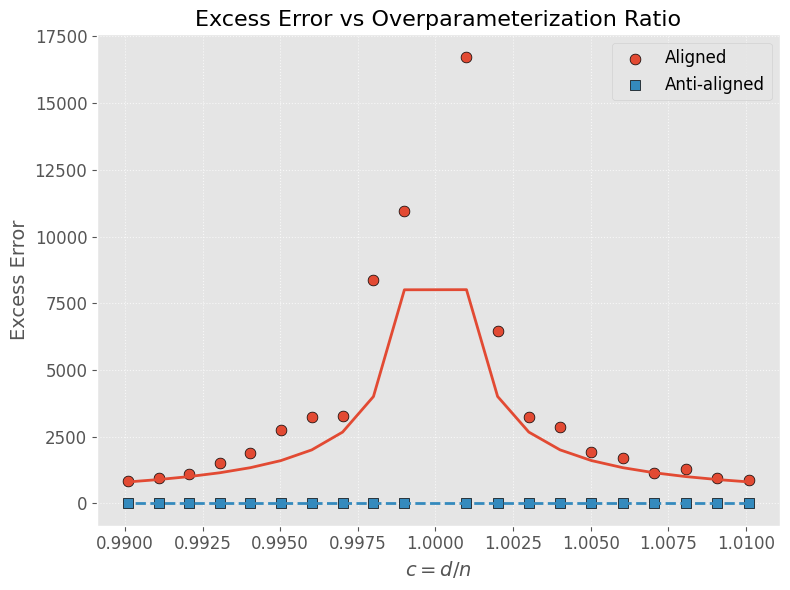

In [ ]:
import matplotlib.pyplot as plt

# Option A: use a built-in Matplotlib style
plt.style.use("ggplot")     # or "bmh", "seaborn", etc.

# Option B (if you have seaborn installed):
# import seaborn as sns
# sns.set_style("whitegrid")

# Prepare your data as NumPy arrays for plotting
c = (d/torch.tensor(Ns)).cpu().numpy()
err = errors.cpu().numpy()
th = theorys.cpu().numpy()
err_anti = errors_anti.cpu().numpy()
th_anti = theorys_anti.cpu().numpy()

fig, ax = plt.subplots(figsize=(8, 6))

# Aligned
ax.scatter(c, err,
           marker='o', s=60, edgecolor='k', label="Aligned")
ax.plot(c, th,
        linestyle='-', linewidth=2)

# Anti-aligned
ax.scatter(c, err_anti,
           marker='s', s=60, edgecolor='k', label="Anti-aligned")
ax.plot(c, th_anti,
        linestyle='--', linewidth=2)

ax.set_xlabel(r"$c = d/n$", fontsize=14)
ax.set_ylabel("Excess Error", fontsize=14)
ax.set_title("Excess Error vs Overparameterization Ratio", fontsize=16)

# ax.axvline(x = 2, label = r"$c = 2$", color = "green")
# ax.axvline(x = 9/2 + np.sqrt(57)/2, label = r"$c = \frac{9 + \sqrt{57}}{2}$", color = "green")

ax.legend(fontsize=12, frameon=True)

ax.grid(True, linestyle=":", alpha=0.7)
ax.tick_params(axis="both", which="major", labelsize=12)

# plt.yscale("log")
# plt.xscale("log")

plt.tight_layout()

plt.savefig("error_vs_c-operator-norm-alpha_A-"+str(alpha_A)+"-alpha_Z-"+str(alpha_Z)+"-theta=tau.png", dpi=100)

plt.show()

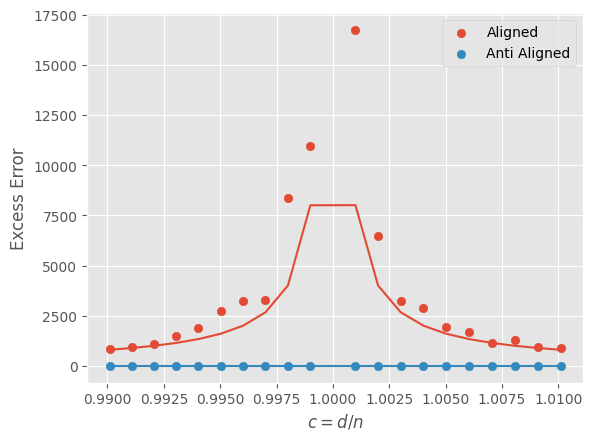

In [ ]:
plt.scatter(d/torch.tensor(Ns).cpu(), errors.cpu(), label="Aligned")
plt.plot(d/torch.tensor(Ns).cpu(), theorys.cpu())
plt.scatter(d/torch.tensor(Ns).cpu(), errors_anti.cpu(), label="Anti Aligned")
plt.plot(d/torch.tensor(Ns).cpu(), theorys_anti.cpu())
plt.xlabel(r"$c = d/n$")
plt.ylabel("Excess Error")
plt.legend()

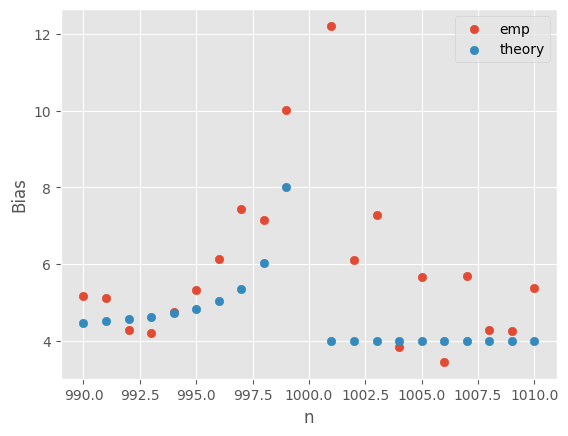

In [ ]:
plt.scatter(Ns, error_decomp[0,:].cpu(), label="emp")
plt.scatter(Ns, theorys_decomp[0,:].cpu(), label='theory')
plt.ylabel("Bias")
plt.xlabel("n")
plt.legend()

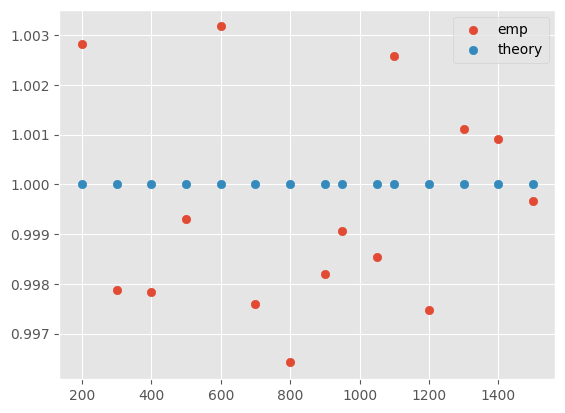

In [ ]:
plt.scatter(Ns, error_decomp[1,:].cpu(), label="emp")
plt.scatter(Ns, theorys_decomp[1,:].cpu(), label='theory')
plt.legend()

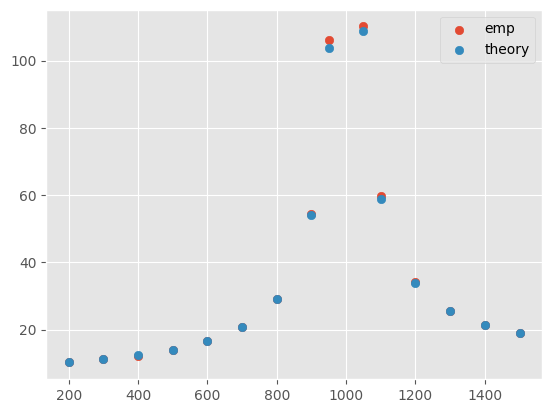

In [ ]:
plt.scatter(Ns, error_decomp[2,:].cpu(), label="emp")
plt.scatter(Ns, theorys_decomp[2,:].cpu(), label='theory')
plt.legend()

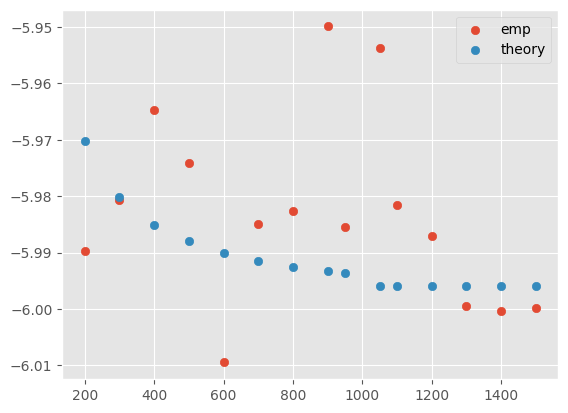

In [ ]:
plt.scatter(Ns, error_decomp[3,:].cpu(), label="emp")
plt.scatter(Ns, theorys_decomp[3,:].cpu(), label='theory')
plt.legend()

In [ ]:
errors

tensor([ 0.6872,  0.9860,  1.7198,  4.0941,  9.2438, 10.1979,  4.9921,  2.5008,
         1.6914], device='cuda:0')

# Alignment Plots

In [ ]:
def get_model(input_size=750, hidden_size=1000, output_size=1):
  return torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, output_size)
  )

def train_model(X, y, model, epochs=100, learning_rate=0.0001):
  """Trains a PyTorch model using gradient descent.

  Args:
    X: The input features.
    y: The target variable.
    model: The PyTorch model to train.
    epochs: The number of training epochs.
    learning_rate: The learning rate for the optimizer.

  Returns:
    The trained PyTorch model.
  """

  # Define the loss function and optimizer
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  # Train the model
  for epoch in range(epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss for monitoring
    # if (epoch + 1) % 1 == 0:
    #   print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

  return model

In [ ]:
n = 500
d = 750

tau = np.sqrt(d)
alpha_A = 1
alpha_A_t = 1
alpha_Z = 4
alpha_Z_t = 4
tau_e = 1

beta_star = torch.randn(d,1)
beta_star = beta_star/torch.norm(beta_star)

angles = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]
T = 50

errors = torch.zeros(len(angles))
error_decomp = torch.zeros(4,len(angles))

bias_theory_formula = torch.zeros(len(angles))
noise_theory_formula = torch.zeros(len(angles))
variance_theory_formula = torch.zeros(len(angles))
alignment_theory_formula = torch.zeros(len(angles))

theorys = torch.zeros(len(angles))
theorys_decomp = torch.zeros(4,len(angles))


for i,angle in tqdm(list(enumerate(angles))):

  u = generate_angle_vector(beta_star, angle)

  align = (beta_star.T @ u)**2
  Delta = (alpha_A - alpha_Z)
  c = d/n

  v = torch.randn(n,1)
  v = v/torch.norm(v)

  v_t = torch.randn(n,1)
  v_t = v_t/torch.norm(v_t)

  theta = np.sqrt(n) * tau
  theta_t = np.sqrt(n) * tau

  theorys[i] = theory(n, d, tau, beta_star, u, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e)

  theorys_decomp[0,i] = bias_theory(n, d, tau, beta_star, u, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e)
  theorys_decomp[1,i] = noise_theory(n, d, tau, beta_star, u, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e)
  theorys_decomp[2,i] = variance_theory(n, d, tau, beta_star, u, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e)
  theorys_decomp[3,i] = alignment_theory(n, d, tau, beta_star, u, theta, theta_t, alpha_A, alpha_A_t, alpha_Z, alpha_Z_t, tau_e)
  for _ in range(T):
    A = torch.randn(d,n) * (tau / np.sqrt(d))
    Z = theta * u @ v.T
    X = Z + A

    y = beta_star.T @ (alpha_Z * Z + alpha_A * A)
    y = y + torch.randn_like(y) * tau_e
    # beta = (y @ torch.linalg.pinv(X)).T
    model = get_model()
    model = train_model(X.T, y.T, model)

    A_t = torch.randn(d,n) * (tau / np.sqrt(d))
    Z_t = theta_t * u @ v_t.T
    X_t = alpha_Z_t * Z_t + alpha_A_t * A_t
    y_t = beta_star.T @ X_t

    # y_p = beta.T @ (Z_t + A_t)
    y_p = model((Z_t + A_t).T).T

    errors[i] += (y_p - y_t).square().sum().detach()/(n*T)

    # error_decomp[0, i] += (beta_star.T @ (alpha_Z_t * Z_t) - beta.T @ Z_t).square().sum()/(n*T)
    # error_decomp[1, i] += (alpha_A_t * beta_star.T @ A_t).square().sum()/(n*T)
    # error_decomp[2, i] += (beta.T @ A_t).square().sum()/(n*T)
    # error_decomp[3, i] -= 2*(alpha_A_t * beta_star.T @ A_t @ A_t.T @ beta).item()/(n*T)

100%|██████████| 19/19 [02:09<00:00,  6.84s/it]


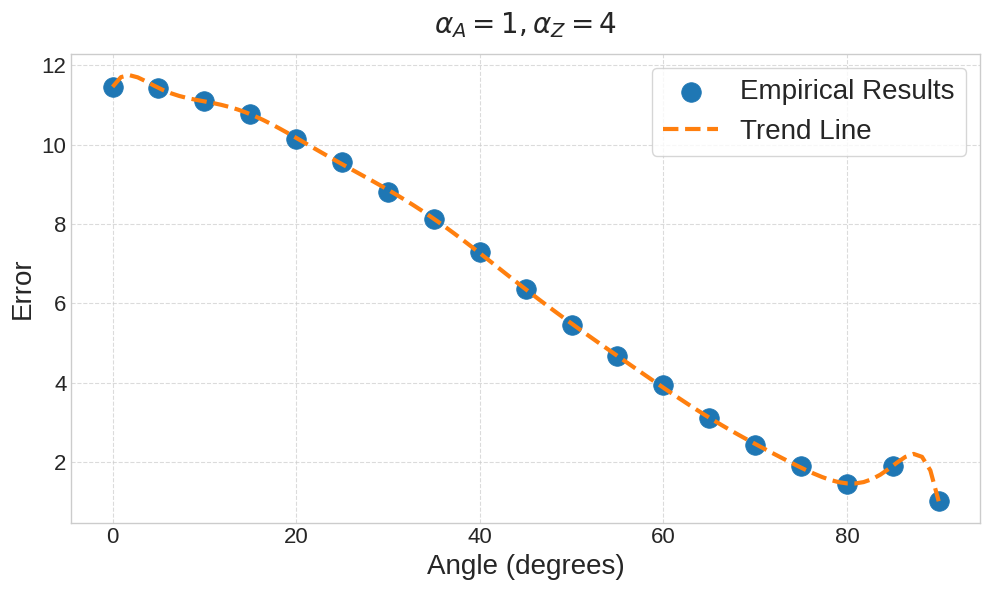

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Set a professional style
plt.style.use('seaborn-v0_8-whitegrid')

# Increase figure size and DPI for better visibility
plt.figure(figsize=(10, 6), dpi=100)

# Create the scatter plot with improved aesthetics
plt.scatter(angles, errors.detach().cpu(), label="Empirical Results",
           color='#1f77b4', s=200, linewidths=0.5)

# Add a trend line to highlight the pattern
z = np.polyfit(angles, errors.detach().cpu().numpy(), 12)
p = np.poly1d(z)
x_trend = np.linspace(min(angles), max(angles), 100)
plt.plot(x_trend, p(x_trend), '--', color='#ff7f0e', linewidth=3,
         label=f"Trend Line")

# Clean up title with more informative content
plt.title(r"$α_A = 1, α_Z = 4$",
          fontsize=20, pad=15)

# Improve axis labels
plt.xlabel("Angle (degrees)", fontsize=20)
plt.ylabel("Error", fontsize=20)

# plt.yscale("log")

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Enhance the legend
plt.legend(frameon=True, fontsize=20, loc='best')

# Add grid for easier reading of values
plt.grid(True, linestyle='--', alpha=0.7)

# Add a text box with parameters
# props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# plt.text(0.05, 0.95, "Parameters:\nα_A = 1, \nα_Z = 4\n3-layer ReLU",
#          transform=plt.gca().transAxes, fontsize=20,
#          verticalalignment='top', bbox=props)

# Tight layout to ensure everything fits well
plt.tight_layout()

# Save the figure with high resolution if needed
plt.savefig('error_vs_angle_plot-large-alpha_z-3-network.png', dpi=100, bbox_inches='tight')

plt.show()